# Import

In [3]:
import os
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters

In [7]:
align_path = 'C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203'
cipher_path = 'C:/Users/01sun/source/repos/raspberrypi/trace_20250124'
result_path = 'C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge'

# Step4-1 alignment 할때 reference 파형 인덱스
referenceTraceIndex = 350404

# Function

In [3]:
def get_sorted_numbers(folder_path, pattern_str):
    # 주어진 폴더에서 특정 패턴을 만족하는 파일의 숫자 부분만 추출하여 정렬
    pattern = re.compile(pattern_str)
    all_files = os.listdir(folder_path)
    
    numbers = []
    for file_name in all_files:
        match = pattern.match(file_name)
        if match:
            number = int(match.group(1))  # 숫자 부분 추출
            numbers.append(number)
    
    numbers.sort()  # 오름차순 정렬
    return numbers

def print_summary(numbers, preview_count=5):
    # 정렬된 숫자 리스트의 일부만 출력하고 총 개수를 표시
    total_count = len(numbers)
    print(f"Total count: {total_count}")
    
    if total_count > preview_count * 2:
        print(f"First {preview_count} numbers: {numbers[:preview_count]}")
        print(f"Last {preview_count} numbers: {numbers[-preview_count:]}")
    else:
        print(f"All numbers: {numbers}")

def load_and_stack_data_in_chunks(folder_path, sorted_numbers, file_prefix, dtype, expected_shape=None, chunk_size=5000):
    # 파일을 Chunk 단위로 로드하여 2차원 배열로 변환 (메모리 초과 방지)
    total_files = len(sorted_numbers)
    stacked_data_list = []
    
    for chunk_start in tqdm(range(0, total_files, chunk_size), desc=f"Processing {file_prefix} chunks"):
        chunk_end = min(chunk_start + chunk_size, total_files)
        chunk_numbers = sorted_numbers[chunk_start:chunk_end]
        
        data_list = []
        for number in chunk_numbers:
            file_path = os.path.join(folder_path, f'{file_prefix}{number}.npy')
            
            if os.path.exists(file_path):
                data = np.load(file_path).astype(dtype)  # 데이터 로드 및 형 변환
                if expected_shape is None or data.shape == expected_shape:  # 올바른 형태인지 검증
                    data_list.append(data)
                else:
                    print(f"Warning: {file_path} has an unexpected shape {data.shape}. Skipping...")
            else:
                print(f"Warning: {file_path} does not exist. Skipping...")
        
        # 현재 Chunk 데이터를 2차원 배열로 변환 후 누적 저장
        if data_list:
            stacked_chunk = np.vstack(data_list)
            stacked_data_list.append(stacked_chunk)

    # 최종 2차원 배열로 변환
    if stacked_data_list:
        final_stacked_data = np.vstack(stacked_data_list)
        print(f"Final stacked data shape: {final_stacked_data.shape}")
        return final_stacked_data
    else:
        print("No valid data found.")
        return None

# File Merge

In [4]:
# alignTrace에서 숫자 리스트 가져오기 (이것을 cipher에도 사용)
align_sorted_numbers = get_sorted_numbers(align_path, r'alignTrace(\d+)\.npy')

# 정렬된 숫자 리스트 요약 출력
print_summary(align_sorted_numbers, preview_count=5)

# alignTrace 데이터를 Chunk-wise 2차원 배열로 변환 (np.float32)
aligntraces = load_and_stack_data_in_chunks(align_path, align_sorted_numbers, 'alignTrace', dtype=np.float32)
# 변환된 데이터를 저장
if aligntraces is not None:
    align_save_path = os.path.join(result_path, 'alignTrace.npy')
    np.save(align_save_path, aligntraces)
    print(f"Saved: {align_save_path}")

traces = load_and_stack_data_in_chunks(align_path, align_sorted_numbers, 'trace', dtype=np.float32)
if traces is not None:
    trace_save_path = os.path.join(result_path, 'trace.npy')
    np.save(trace_save_path, traces)
    print(f"Saved: {trace_save_path}")

ciphertexts = load_and_stack_data_in_chunks(cipher_path, align_sorted_numbers, 'cipher_', dtype=np.uint8, expected_shape=(16,))
if ciphertexts is not None:
    cipher_save_path = os.path.join(result_path, 'cipher.npy')
    np.save(cipher_save_path, ciphertexts)
    print(f"Saved: {cipher_save_path}")

Total count: 141687
First 5 numbers: [8, 13, 17, 22, 27]
Last 5 numbers: [999940, 999946, 999966, 999969, 999985]


Processing alignTrace chunks: 100%|████████████████████████████████████████████████████| 29/29 [14:19<00:00, 29.65s/it]


Final stacked data shape: (141687, 26000)
Saved: C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge\alignTrace.npy


Processing trace chunks: 100%|█████████████████████████████████████████████████████████| 29/29 [12:10<00:00, 25.18s/it]


Final stacked data shape: (141687, 26000)
Saved: C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge\trace.npy


Processing cipher_ chunks: 100%|███████████████████████████████████████████████████████| 29/29 [07:25<00:00, 15.35s/it]

Final stacked data shape: (141687, 16)
Saved: C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge\cipher.npy


# referenceTraceIndex check

In [21]:
align_sorted_numbers = get_sorted_numbers(align_path, r'alignTrace(\d+)\.npy')
print_summary(align_sorted_numbers, preview_count=5)

index = align_sorted_numbers.index(referenceTraceIndex)
print(f"referenceTraceIndex = {index}")

Total count: 18316
First 5 numbers: [8, 116, 130, 249, 256]
Last 5 numbers: [999791, 999793, 999824, 999884, 999985]
referenceTraceIndex = 6267


# Overlap(trace)

In [18]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 12

axisFontSize  = 14
titleFontSize = 20

In [19]:
from scipy import signal

samplingFrequency = int(5e9)  # unit: Hz (set this from the setting of oscilloscope)
windowLength      = 1000      # The number of samples in the window.
noverlap          = None    # Number of points to overlap between segments. If None, noverlap = nperseg // 8. Defaults to None.

filterOrder  = int(1e2 - 1)            # Length of the filter (number of coefficients, i.e. the filter order + 1). numtaps must be odd if a passband includes the Nyquist frequency
filterWidth  = None                    # If width is not None, then assume it is the approximate width of the transition region (expressed in the same units as fs) for use in Kaiser FIR filter design. In this case, the window argument is ignored.
bandPassFreq = [int(1e7), int(1e8)]#, int(895e6), int(905e6), int(995e6), int(1005e6)]#[int(15e6), int(25e6)]  # Cutoff frequency of filter (expressed in the same units as fs) OR an array of cutoff frequencies (that is, band edges). In the latter case, the frequencies in cutoff should be positive and monotonically increasing between 0 and fs/2. The values 0 and fs/2 must not be included in cutoff.

firCoeff = signal.firwin(numtaps=filterOrder, cutoff=bandPassFreq, width=filterWidth, window='hamming', fs=samplingFrequency, pass_zero=False)

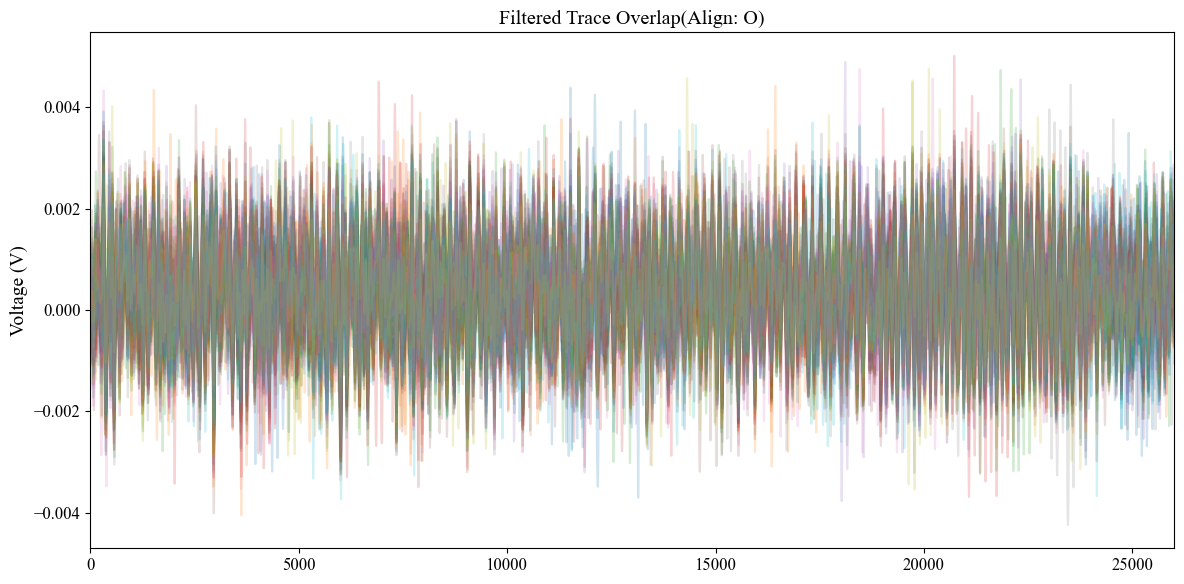

(141687, 26000)


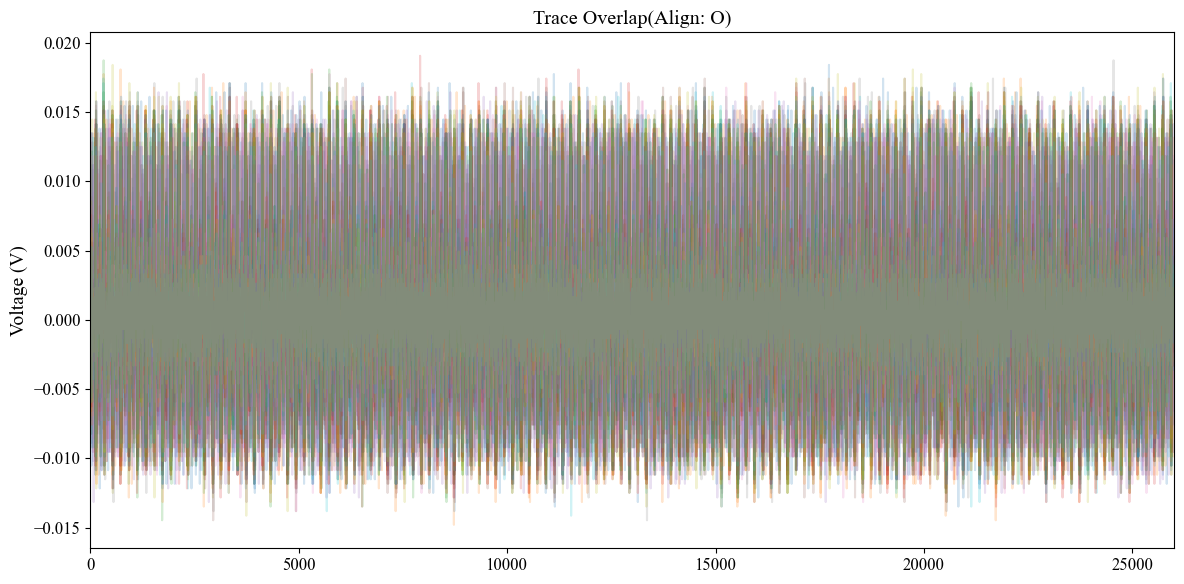

In [14]:
filtered_traces = np.load('C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge/filtered_Trace.npy')
plt.figure(figsize=(12, 6))
plt.plot(filtered_traces[:100].T, alpha=0.2)
plt.title('Filtered Trace Overlap(Align: O)')
plt.xlim(0, filtered_traces.shape[1])
plt.ylabel('Voltage (V)', fontsize=axisFontSize)
plt.tight_layout()
plt.savefig('{}/filtered_traces_overlap.png'.format(result_path), dpi=300)
plt.show()

traces = np.load('C:/Users/01sun/source/repos/raspberrypi/trace_20250124/alignment_and_drop_GPU_20250203/TraceMerge/trace.npy')
print(traces.shape)
plt.figure(figsize=(12, 6))
plt.plot(traces[:100].T, alpha=0.2)
plt.title('Trace Overlap(Align: O)')
plt.xlim(0, traces.shape[1])
plt.ylabel('Voltage (V)', fontsize=axisFontSize)
plt.tight_layout()
plt.savefig('{}/traces_overlap.png'.format(result_path), dpi=300)
plt.show()

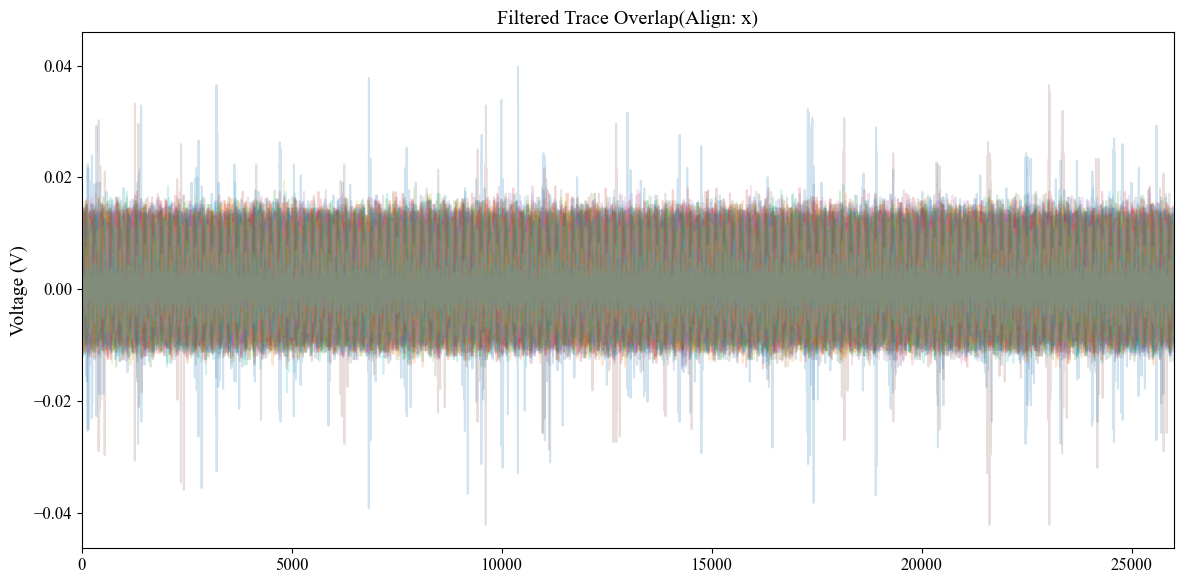

In [22]:
plt.figure(figsize=(12, 6))
for traceIndex in range(100):
    trace = np.load(f'C:/Users/01sun/source/repos/raspberrypi/trace_20250124/trace_{traceIndex}.npy')
    plt.plot(trace, alpha=0.2)
plt.title('Filtered Trace Overlap(Align: x)')
plt.xlim(0, filtered_traces.shape[1])
plt.ylabel('Voltage (V)', fontsize=axisFontSize)
plt.tight_layout()
plt.savefig('{}/traces_overlap(align x).png'.format(result_path), dpi=300)
plt.show()

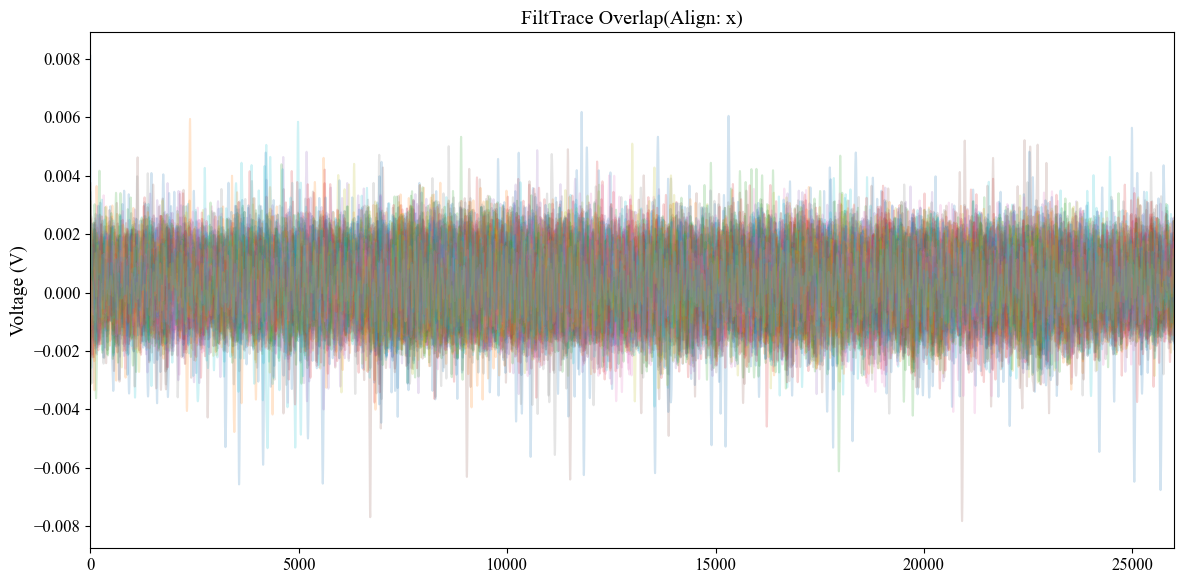

In [24]:
plt.figure(figsize=(12, 6))

for traceIndex in range(100):
    trace = np.load(f'C:/Users/01sun/source/repos/raspberrypi/trace_20250124/trace_{traceIndex}.npy')
    filteredTrace = signal.filtfilt(b=firCoeff, a=1.0, x=trace)
    plt.plot(filteredTrace, alpha=0.2)
plt.title('FiltTrace Overlap(Align: x)')
plt.xlim(0, filtered_traces.shape[1])
plt.ylabel('Voltage (V)', fontsize=axisFontSize)
plt.tight_layout()
plt.savefig('{}/filtered_traces_overlap(align x).png'.format(result_path), dpi=300)
plt.show()